In [9]:
from data_repo import ystock as ys
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
client = ys.ystock()

In [12]:
# We are going to use the S&P 500 to do the time series analysis
symbol = "^GSPC"
info = client.getCompanyInfo(symbol)
print(info)

{'previousClose': 2799.31, 'regularMarketOpen': 2810.42, 'twoHundredDayAverage': 3035.3494, 'trailingAnnualDividendYield': None, 'payoutRatio': None, 'volume24Hr': None, 'regularMarketDayHigh': 2844.9, 'navPrice': None, 'averageDailyVolume10Day': 5295360000, 'totalAssets': None, 'regularMarketPreviousClose': 2799.31, 'fiftyDayAverage': 2658.0625, 'trailingAnnualDividendRate': None, 'open': 2810.42, 'toCurrency': None, 'averageVolume10days': 5295360000, 'expireDate': None, 'yield': None, 'algorithm': None, 'dividendRate': None, 'exDividendDate': None, 'beta': None, 'circulatingSupply': None, 'startDate': None, 'regularMarketDayLow': 2794.26, 'priceHint': 2, 'currency': 'USD', 'regularMarketVolume': 2349901835, 'lastMarket': None, 'maxSupply': None, 'openInterest': None, 'marketCap': None, 'volumeAllCurrencies': None, 'strikePrice': None, 'averageVolume': 5727568412, 'priceToSalesTrailing12Months': None, 'dayLow': 2794.26, 'ask': 2809.64, 'ytdReturn': None, 'askSize': 0, 'volume': 234990

In [62]:
chart = client.getHistorical(symbol,"2y")
print(chart)

               Open     High      Low    Close      Volume  Dividends  \
Date                                                                    
2018-04-24  2680.80  2683.55  2617.32  2634.56  3706740000          0   
2018-04-25  2634.92  2645.30  2612.67  2639.40  3499440000          0   
2018-04-26  2651.65  2676.48  2647.16  2666.94  3665720000          0   
2018-04-27  2675.47  2677.35  2659.01  2669.91  3219030000          0   
2018-04-30  2682.51  2682.87  2648.04  2648.05  3734530000          0   
...             ...      ...      ...      ...         ...        ...   
2020-04-17  2842.43  2879.22  2830.88  2874.56  5792140000          0   
2020-04-20  2845.62  2868.98  2820.43  2823.16  5220160000          0   
2020-04-21  2784.81  2785.54  2727.10  2736.56  5075830000          0   
2020-04-22  2787.89  2815.10  2775.95  2799.31  5049660000          0   
2020-04-23  2810.42  2844.90  2794.26  2797.80  2905751151          0   

            Stock Splits  
Date                   

In [63]:
# Drop cols
cols = ['Open', 'High', 'Low', 'Volume','Dividends','Stock Splits']
chart.drop(cols, axis=1,inplace=True)
chart.isnull().sum()

Close    0
dtype: int64

In [64]:
chart

,Close
Date,
2018-04-24,2634.56
2018-04-25,2639.40
2018-04-26,2666.94
2018-04-27,2669.91
2018-04-30,2648.05
...,...
2020-04-17,2874.56
2020-04-20,2823.16
2020-04-21,2736.56


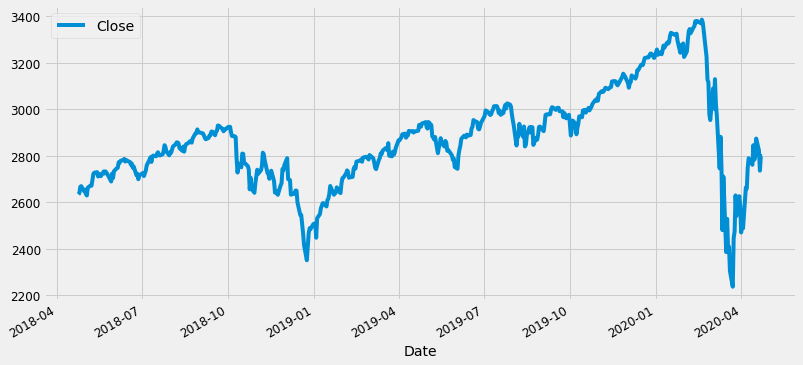

In [65]:
chart.plot(figsize=(12,6))
plt.show()

In [66]:
df = chart['Close'].resample('B').fillna("backfill")
df

Date
2018-04-24    2634.56
2018-04-25    2639.40
2018-04-26    2666.94
2018-04-27    2669.91
2018-04-30    2648.05
               ...   
2020-04-17    2874.56
2020-04-20    2823.16
2020-04-21    2736.56
2020-04-22    2799.31
2020-04-23    2797.80
Freq: B, Name: Close, Length: 523, dtype: float64

In [67]:
df.isna().sum()

0

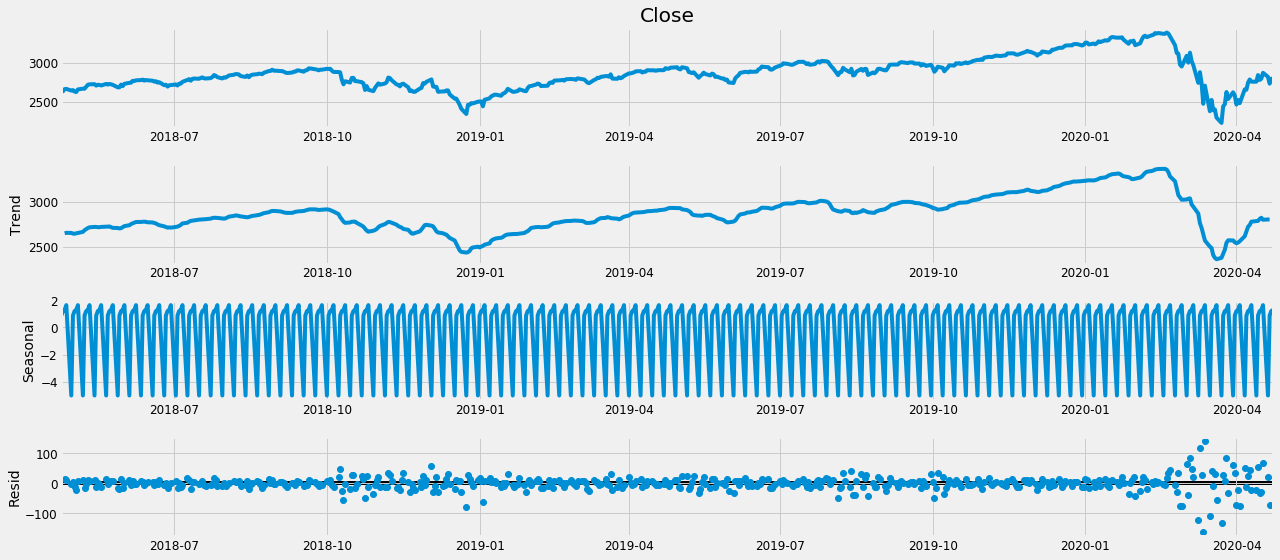

In [68]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

In [70]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [74]:
lowest_aic = 1000000
best_pdq = ()
best_spdq = ()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            reaic = results.aic
            if reaic < lowest_aic:
                lowest_aic = reaic
                best_pdq = param
                best_spdq = param_seasonal
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
print('best aic = {}, pdq = {}, spdq = {}'.format(lowest_aic, best_pdq, best_spdq))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:9799.275583163757
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:8906.920660435588
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:6477.4144989887445
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6331.273261894014
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:6491.518469535328
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6476.576212225171
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6345.881700725482
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6323.691355954377
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:9071.341462947621
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8208.524029674109
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:6065.7989933786175
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:5924.71249955866


c:\users\owner\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:6508.481511435255
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:6061.87297663623
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:5952.464624961362
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:5898.349224194059
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5371.0701401178385
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5255.300184783879
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:5555.510071589311
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:5169.678408976544
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:5264.775552203103
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:5257.299249183501
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:5326.4036790947775
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:5171.608296931335
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:5330.737840525893
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:5217.649158570591
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:5528.802897348423
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:5133.691663505793
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:5236.343523149049
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:5219.591163531864
ARIMA(0, 

c:\users\owner\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:5266.664231897332
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:5545.9178713198835
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:5175.170704215212
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:5266.79020135961
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:5268.624566715145
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:5317.182412456383
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:5177.111246627279
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:5342.4780619864305


c:\users\owner\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:5229.527259931187
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:5525.899550700856
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:5141.79420129399
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:5238.374139287783
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:5230.917273724079
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:5300.33802989795
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:5143.738143548251
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:5327.383724370635
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:5214.65725436458
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:5532.646997858073
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:5131.930660193764
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:5214.761862183475
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:5216.617583263546
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:5284.792933702485
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:5133.922443587506
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:5314.191359596121
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:5201.933394174531
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:5516.800902747238
ARIMA(1, 1, 1

In [78]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5021      0.051     -9.853      0.000      -0.602      -0.402
ma.L1          0.2325      0.058      4.041      0.000       0.120       0.345
ma.S.L12      -0.9401      0.019    -49.284      0.000      -0.978      -0.903
sigma2      1685.9082     40.470     41.658      0.000    1606.589    1765.228


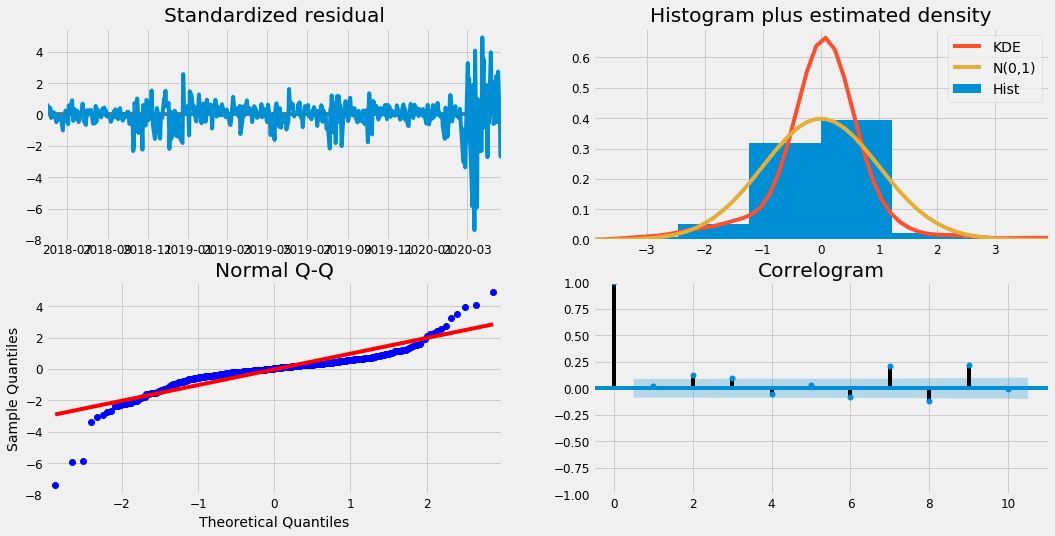

In [79]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

In [81]:
df

Date
2018-04-24    2634.56
2018-04-25    2639.40
2018-04-26    2666.94
2018-04-27    2669.91
2018-04-30    2648.05
               ...   
2020-04-17    2874.56
2020-04-20    2823.16
2020-04-21    2736.56
2020-04-22    2799.31
2020-04-23    2797.80
Freq: B, Name: Close, Length: 523, dtype: float64

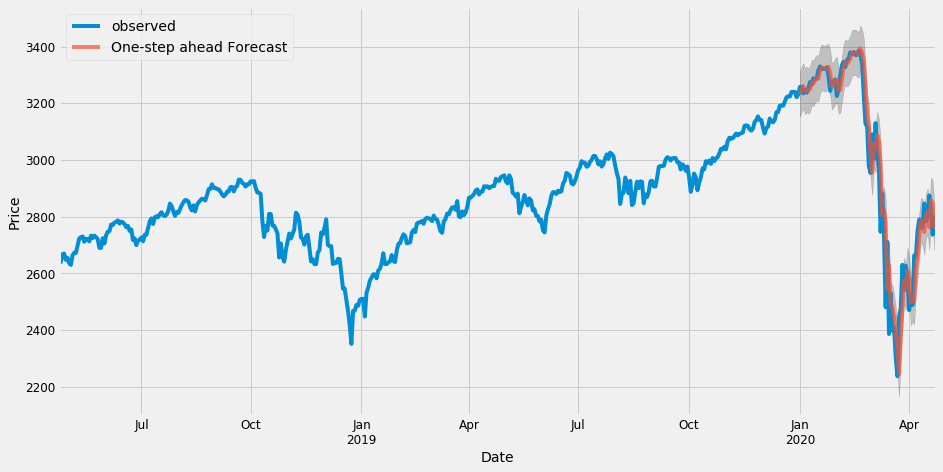

In [82]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [85]:
df_forecasted = pred.predicted_mean
df_truth = df['2020-01-01':]
mse = ((df_forecasted - df_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 6926.26
The Root Mean Squared Error of our forecasts is 83.22


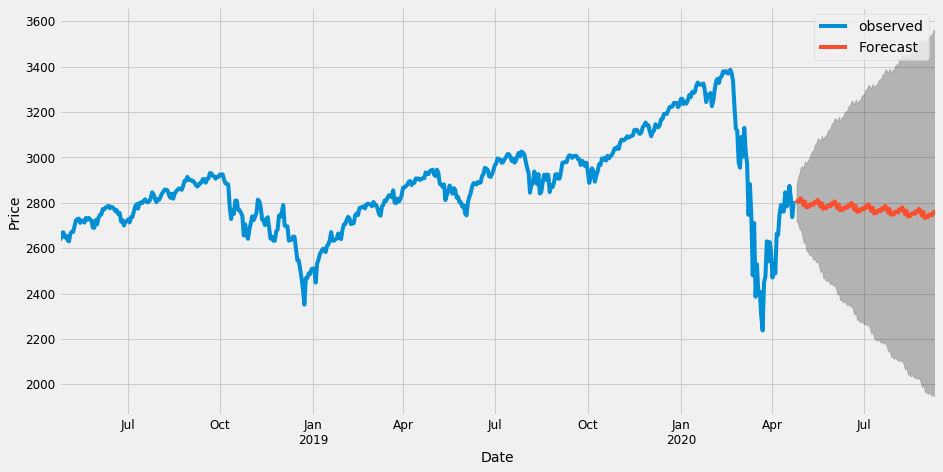

In [89]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()